# Random-forest-demo

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestRegressor # RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error # accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [89]:
data_dir = Path('C:\DACON\dataset')
sub_dir = Path('C:\DACON\/build')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'submission.csv'

target_col = 'count'
seed = 12

In [94]:
algo_name = 'rf'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

# feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'
print(sub_file)

C:\DACON\build\rf_feature.csv


In [57]:
trn = pd.read_csv(trn_file, index_col=0)
tst = pd.read_csv(tst_file, index_col=0)
# df = df.dropna(axis=0)
# 앞의 값으로 결측치 채우기
trn = trn.fillna(method='ffill')
tst = tst.fillna(method='ffill')

print(trn.shape, tst.shape)
trn.head()

(1459, 10) (715, 9)


,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
id,,,,,,,,,,
3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [58]:
# y = df[target_col].values[:1100]
# df.drop(target_col, axis=1, inplace=True)
# print(df.shape)
y = trn[target_col]
trn.drop(target_col, axis=1, inplace=True)

# trn = df.iloc[:1100]
# tst = df.iloc[1100:]
feature_name = trn.columns.tolist()
# feature_name = ['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_ozone']
# trn = trn[feature_name]
# tst = tst[feature_name]

print(y.shape, trn.shape, tst.shape)
print(feature_name)

(1459,) (1459, 9) (715, 9)
['hour', 'hour_bef_temperature', 'hour_bef_precipitation', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5']


## 학습/검증 데이터 구분

In [59]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(1167, 9) (292, 9) (1167,) (292,)


## Random forest 모델 학습
dku 예제에서는 classifier, accuracy_score를 사용
모델과 metrics를 regressor, r2(or mse)로 수정

In [60]:
clf = RandomForestRegressor(n_estimators=100,
                             min_samples_leaf=10,
                             max_features='auto',
                             max_samples=.5,
                             random_state=seed,
                             n_jobs=-1)
clf.fit(X_trn, y_trn)
p_val = clf.predict(X_val)
p_tst = clf.predict(tst)

In [61]:
print('r2:', f'{r2_score(y_val, p_val):.4f}')
print('mse:', f'{mean_squared_error(y_val, p_val):.4f}')

r2: 0.7604
mse: 0.7604


## 피처 중요도 시각화

<AxesSubplot:ylabel='feature'>

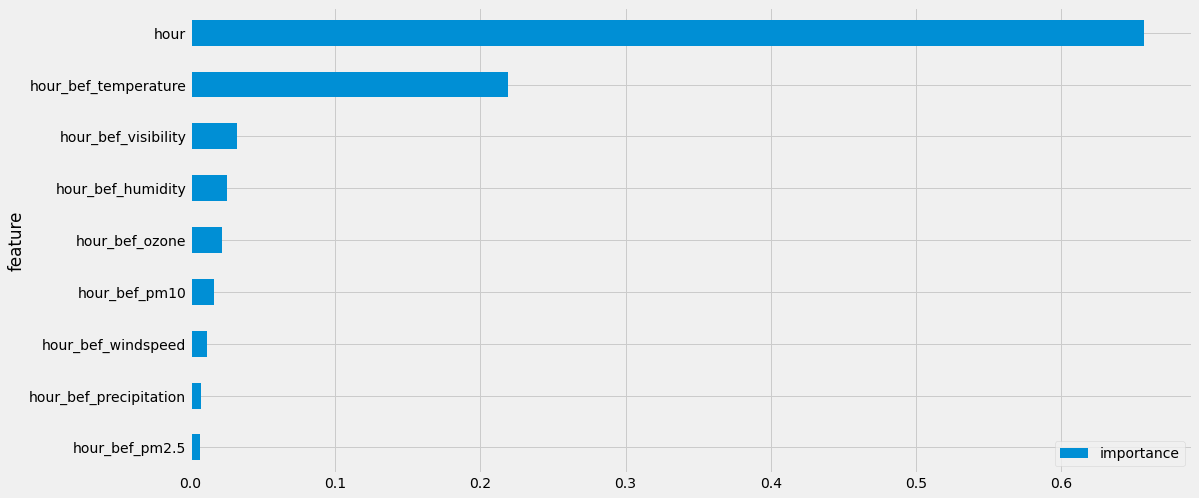

In [62]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [63]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(715, 1)


,count
id,
0,NaN
1,NaN
2,NaN
4,NaN
5,NaN


In [97]:
sub[target_col] = p_tst.round().astype(int) # count는 int형
sub.head()

,count
id,
0,89
1,234
2,100
4,32
5,78


In [72]:
sub[target_col].value_counts()

28.0     18
27.0     18
26.0     13
107.0    11
80.0     11
         ..
170.0     1
87.0      1
251.0     1
171.0     1
260.0     1
Name: count, Length: 233, dtype: int64

In [98]:
sub.to_csv(sub_file)